In [1]:
from glob import glob
import os
from pathlib import Path
from denovo_utils.parsers.constants import EXTENSIONS
from pyteomics import mgf

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from psm_utils.io import read_file, write_file
from psm_utils import PSMList, PSM

from tqdm import tqdm

from denovo_utils.parsers.converters import SpectralisParser, DenovoEngineConverter

# Parsing scripts

---

### 1. Check if parsing scripts work as expected

In [2]:
os.path.basename("/home/samva/Doctorate/data_directory/denovo_project/denovo_results")

'denovo_results'

In [3]:
root_result = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results"
root_mgf = "/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered"

def match_mgf_result(root_result, root_mgf):
    denovo = os.path.basename(root_result)

    mgf_result_dir = {}

    for path_mgf in glob(os.path.join(root_mgf, "*.mgf")):
        filename_mgf = os.path.basename(path_mgf).split(".")[0]
        for path_result in glob(os.path.join(root_result, f"*{EXTENSIONS[denovo]}")):
            filename_result = os.path.basename(path_result).split(".")[0]

            if filename_mgf == filename_result:
                mgf_result_dir[filename_mgf] = {
                    "mgf": path_mgf,
                    "result": path_result
                }
    return mgf_result_dir

def evaluate_parser(root_result, root_mgf, denovo):
    evaluation_metrics = {}
    mgf_result_dir = match_mgf_result(
        root_result=os.path.join(root_result, denovo),
        root_mgf=root_mgf
    )

    for filename, mgf_result in mgf_result_dir.items():
        parser = DenovoEngineConverter.select(denovo)
        psmlist = parser.parse(
            result_path=mgf_result["result"],
            mgf_path=mgf_result["mgf"]
        )
        evaluation_metrics[filename] = {
            "length_result": len(psmlist),
            "length_mgf": len(mgf.read(mgf_result["mgf"]))
        }
    return evaluation_metrics

In [4]:
metrics_pepnovo = evaluate_parser(
    root_result=root_result,
    root_mgf=root_mgf,
    denovo="pepnovo"
)

100%|██████████| 201050/201050 [00:03<00:00, 61974.05it/s]


In [ ]:
evaluation_metrics["pepnovo"] = metrics_pepnovo

In [ ]:
engines = [
    'casanovo',
    'contranovo',
    'instanovo',
    'novob',
    'pepnet',
    'novor',
    'pepnovo',
]

evaluation_metrics = {}
denovo_engine = ""
for denovo_engine in tqdm(engines, desc=f"Evaluated {denovo_engine}"):

    metrics = evaluate_parser(
        root_result=root_result,
        root_mgf=root_mgf,
        denovo=denovo_engine
    )
    evaluation_metrics[denovo_engine] = metrics

---

### 2.  Parse the spectralis output

In [2]:
spectralis_parser = SpectralisParser(
    mgf_path="/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/F01_Fraction1.mgf",
    results_dir="/home/samva/Doctorate/data_directory/denovo_project/denovo_results"
)

In [3]:
spectralis_parser.parse(
    result_path="/home/samva/Doctorate/data_directory/denovo_project/denovo_results/refinement/spectralis/F01_Fraction1_annotated_rescoring.csv"
)

100%|██████████| 4531/4531 [00:00<00:00, 159878.11it/s]


In [4]:
spectralis_parser.added_results

{'Casanovo4.2.0': True, 'InstaNovo': True, 'PepNet': True, 'ContraNovo': True}

In [5]:
spectralis_parser.psmlists

{'casanovo': PSMList(
     psm_list=[
         PSM(
             peptidoform=Peptidoform('DVSSSHSSSTQDA/2'),
             spectrum_id='controllerType=0 controllerNumber=1 scan=4243',
             run='F01_Fraction1.mztab',
             collection=None,
             spectrum=None,
             is_decoy=None,
             score=-0.604119916579553,
             qvalue=None,
             pep=None,
             precursor_mz=652.896728515625,
             retention_time=1928.29764,
             ion_mobility=None,
             protein_list=None,
             rank=None,
             source='Casanovo4.2.0',
             provenance_data={},
             metadata={
                 'aa_scores': '0.24678,0.53034,0.48793,0.28174,0.29437,0.33757,0.37216,0.31484,0.33539,0.35982,0.33577,0.30267,0.65125',
                 'calc_mass_to_charge': '654.2709298168799',
                 'spectra_ref': 'ms_run[1]:index=0',
                 'scans': '4243'
             },
             rescoring_features={'spe

---

### Parsing percolator files and filenames

In [20]:
from glob import glob

# Renaming files
for filename in glob("/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_percolator/*"):
    os.rename(filename, filename.replace("_searchengine_features", ""))

In [49]:
# Splitting and renaming fractionated files

root="/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem-Percolator-og"
target_dir = "/home/samva/Doctorate/data_directory/denovo_project/search_results/XTandem_percolator"
split_files = [
    "F01_F1-4_searchengine_features.pout",
    "F07_F1-4_searchengine_features.pout",
    "S11_F1-4_searchengine_features.pout"
]

for split_file in split_files:
    psmlist = read_file(
        filename=os.path.join(root, split_file),
        filetype="percolator"
    )

    psm_df = psmlist.to_dataframe()
    psm_df["filename"] = psm_df["spectrum_id"].apply(lambda x: "_".join(x.split("_")[:2]))
    psm_df["spectrum_id"] = psm_df["spectrum_id"].apply(lambda x: "_".join(x.split("_")[2:]))

    for f in psm_df.filename.unique():
        psm_selection = psm_df[psm_df.filename==f]
        psmlist_selection = PSMList(
            psm_list=[PSM(**x) for x in psm_selection.to_dict("records")]
        )
        print(f"Writing {f}...")
        write_file(
            psm_list=psmlist_selection,
            filename=os.path.join(target_dir, f+".pout"),
            filetype="percolator",
            style="pout"
        )

Writing F01_Fraction3...
Writing F01_Fraction2...
Writing F01_Fraction4...
Writing F01_Fraction1...
Writing F07_Fraction1...
Writing F07_Fraction2...
Writing F07_Fraction3...
Writing F07_Fraction4...
Writing S11_Fraction1...
Writing S11_Fraction2...
Writing S11_Fraction3...
Writing S11_Fraction4...


---

In [19]:
spectralis_out_processed.scans.nunique()

9157

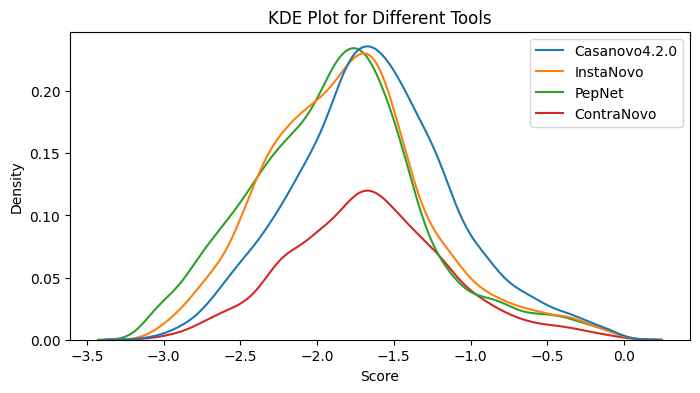

In [38]:
plt.figure(figsize=(8, 4))

scores = {}
for tool in ENGINES:
    scores[tool] = spectralis_out_processed['Spectralis_score'][spectralis_out_processed[tool]].tolist()

sns.kdeplot(
    scores, 
    common_norm=True
)

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('KDE Plot for Different Tools')
plt.show()

In [32]:
spectralis_out_processed.sum(axis=0)

Spectralis_score                                        -53464.435289
scans               controllerType=0 controllerNumber=1 scan=4243c...
Casanovo4.2.0                                                    9045
InstaNovo                                                        8983
PepNet                                                           9157
ContraNovo                                                       4531
filename            F01_Fraction1F01_Fraction1F01_Fraction1F01_Fra...
dtype: object

In [ ]:
spectralis_out_processed